In [28]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
!pip install yfinance


In [15]:
#Import libraries and metrics
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score,roc_curve, classification_report
from sklearn.metrics import confusion_matrix, make_scorer, roc_auc_score
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

In [26]:
pd.options.mode.chained_assignment = None

In [29]:
SONY=yf.download('SONY ', start="2014-01-01", end='2023-12-31')

SONY

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,17.330000,17.389999,17.080000,17.160000,17.160000,2625400
2014-01-03,17.209999,17.260000,17.120001,17.180000,17.180000,928400
2014-01-06,17.299999,17.490000,17.270000,17.299999,17.299999,2356300
2014-01-07,17.360001,17.379999,17.200001,17.320000,17.320000,3438300
2014-01-08,17.400000,18.320000,17.260000,18.250000,18.250000,8572900
...,...,...,...,...,...,...
2023-12-22,91.750000,92.300003,91.510002,92.139999,92.139999,531900
2023-12-26,92.230003,93.650002,92.209999,93.470001,93.470001,660400
2023-12-27,93.620003,94.050003,93.459999,94.010002,94.010002,585400


In [30]:
SONY = SONY.dropna() 
SONY = SONY[['Volume','Open', 'High', 'Low', 'Close']]
SONY

,Volume,Open,High,Low,Close
Date,,,,,
2014-01-02,2625400,17.330000,17.389999,17.080000,17.160000
2014-01-03,928400,17.209999,17.260000,17.120001,17.180000
2014-01-06,2356300,17.299999,17.490000,17.270000,17.299999
2014-01-07,3438300,17.360001,17.379999,17.200001,17.320000
2014-01-08,8572900,17.400000,18.320000,17.260000,18.250000
...,...,...,...,...,...
2023-12-22,531900,91.750000,92.300003,91.510002,92.139999
2023-12-26,660400,92.230003,93.650002,92.209999,93.470001
2023-12-27,585400,93.620003,94.050003,93.459999,94.010002


In [31]:
SONY['H-L'] = SONY['High'] - SONY['Low'] 
SONY['O-C'] = SONY['Close'] - SONY['Open'] 

SONY['3day MA'] = SONY['Close'].shift(1).rolling(window = 3).mean() 
SONY['10day MA'] = SONY['Close'].shift(1).rolling(window = 10).mean() 
SONY['30day MA'] = SONY['Close'].shift(1).rolling(window = 30).mean() 

SONY['Std_dev'] = SONY['Close'].rolling(5).std() 

SONY['Price_Rise'] = np.where(SONY['Close'].shift(-1) > SONY['Close'], 1, 0)

SONY = SONY.dropna() 
SONY.head(10)


,Volume,Open,High,Low,Close,H-L,O-C,3day MA,10day MA,30day MA,Std_dev,Price_Rise
Date,,,,,,,,,,,,
2014-02-14,4011900,16.790001,17.129999,16.790001,17.059999,0.339998,0.269999,17.210000,16.465,16.893000,0.241412,1
2014-02-18,1832700,17.299999,17.389999,17.200001,17.340000,0.189999,0.040001,17.193333,16.596,16.889667,0.124016,0
2014-02-19,2655400,17.110001,17.250000,17.020000,17.070000,0.230000,-0.040001,17.200000,16.805,16.895000,0.132741,1
2014-02-20,1792400,17.100000,17.219999,16.980000,17.170000,0.240000,0.070000,17.156666,16.902,16.887333,0.113886,0
2014-02-21,1403500,17.240000,17.330000,17.120001,17.120001,0.209999,-0.119999,17.193333,17.029,16.882333,0.113886,1
2014-02-24,1963400,17.400000,17.480000,17.320000,17.400000,0.160000,0.000000,17.120000,17.089,16.844667,0.143003,0
2014-02-25,1950800,17.260000,17.350000,17.170000,17.280001,0.180000,0.020000,17.230000,17.147,16.822000,0.132552,1
2014-02-26,1757000,17.350000,17.530001,17.160000,17.379999,0.370001,0.029999,17.266667,17.207,16.804667,0.124096,1
2014-02-27,3096100,17.379999,17.639999,17.270000,17.520000,0.369999,0.140001,17.353333,17.234,16.799000,0.149666,1


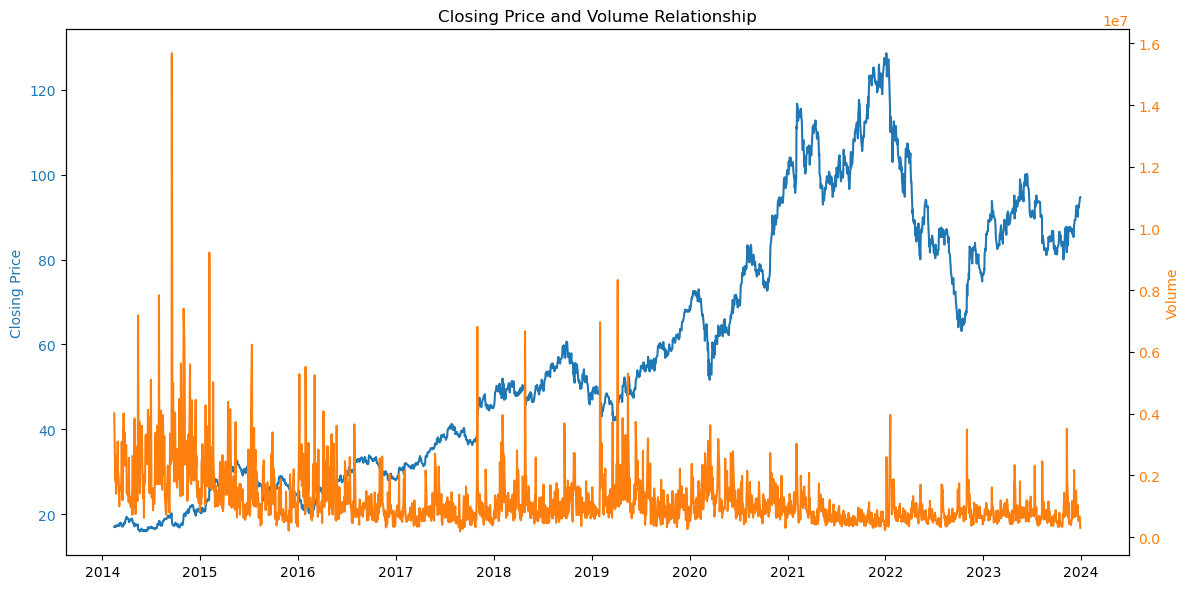

In [32]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_ylabel('Closing Price', color=color)
ax1.plot(SONY['Close'], label='Close', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Volume', color=color)
ax2.plot(SONY['Volume'], label='Volume', color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.title('Closing Price and Volume Relationship')
fig.tight_layout()
plt.show()

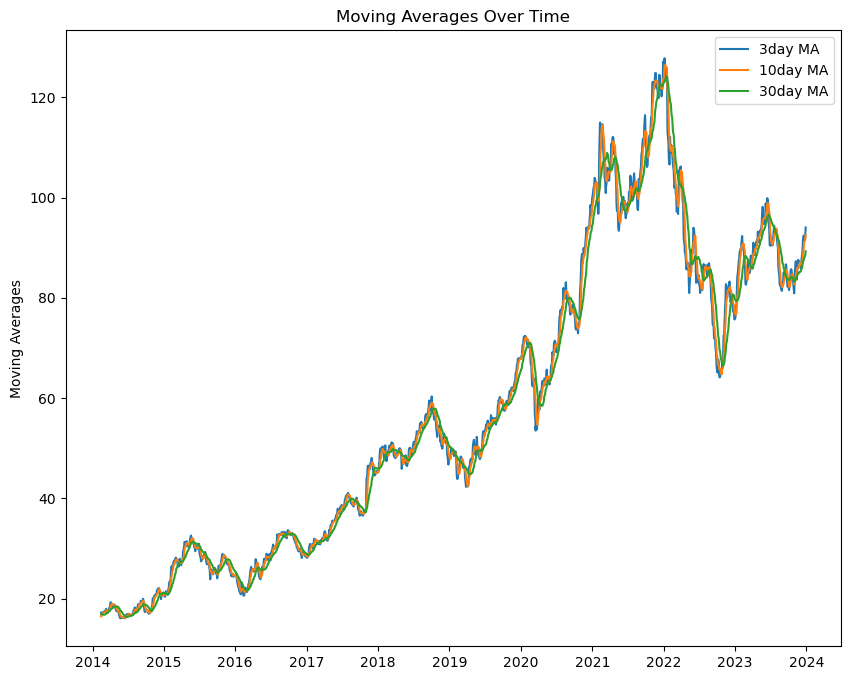

In [33]:
plt.figure(figsize=(10,8 ))

plt.plot(SONY['3day MA'], label='3day MA')
plt.plot(SONY['10day MA'], label='10day MA')
plt.plot(SONY['30day MA'], label='30day MA')

plt.title('Moving Averages Over Time')
plt.ylabel('Moving Averages')
plt.legend()
plt.show()

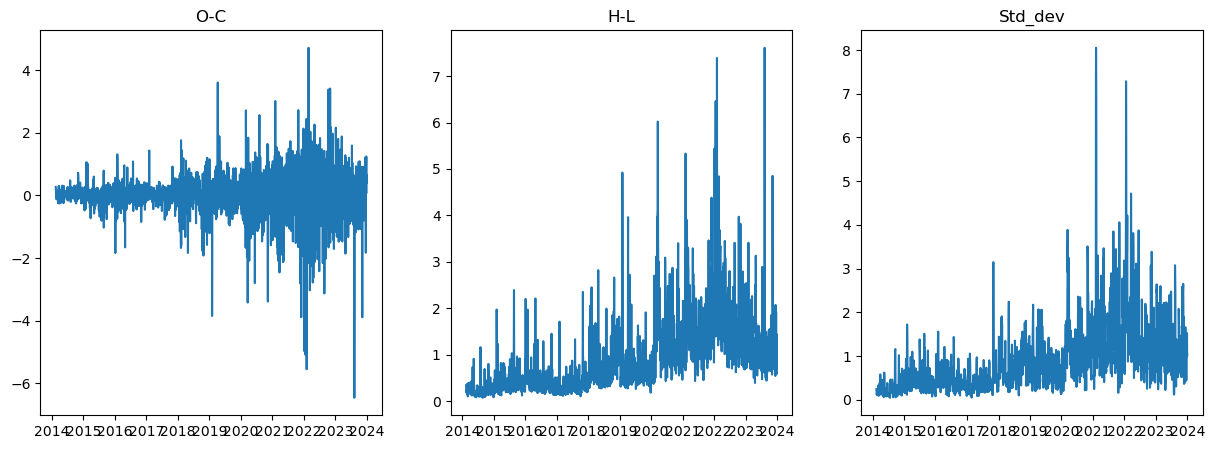

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(SONY['O-C'])
axes[0].set_title('O-C')
axes[1].plot(SONY['H-L'])
axes[1].set_title('H-L')
axes[2].plot(SONY['Std_dev'])
axes[2].set_title('Std_dev')

plt.show()

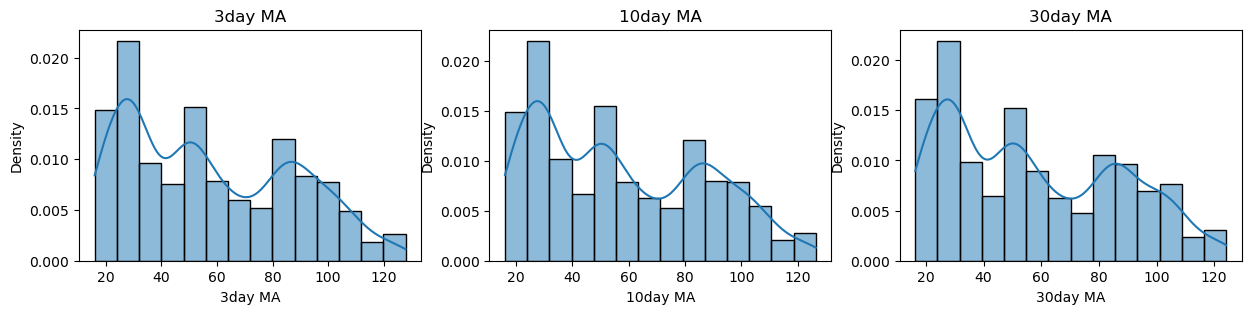

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(15,3))  # 1 row, 3 columns

sns.histplot(data=SONY, x="3day MA", kde=True, stat="density", ax=axes[0])
axes[0].set_title('3day MA')

sns.histplot(data=SONY, x="10day MA", kde=True, stat="density", ax=axes[1])
axes[1].set_title('10day MA')

sns.histplot(data=SONY, x="30day MA", kde=True, stat="density", ax=axes[2])
axes[2].set_title('30day MA')

plt.show()


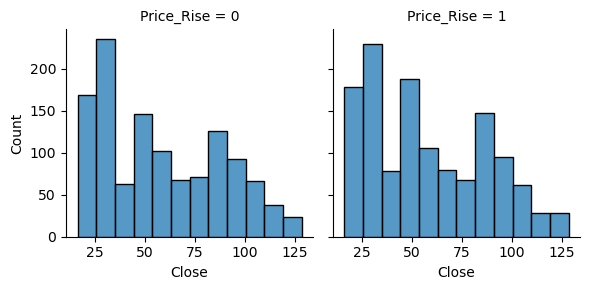

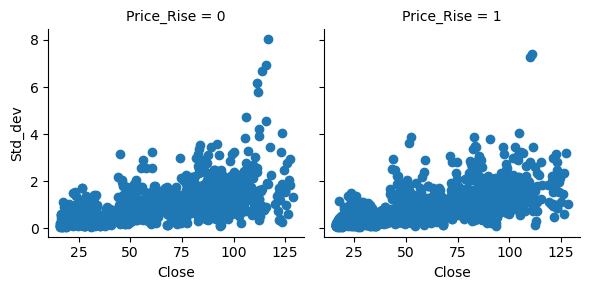

In [37]:
chart = sns.FacetGrid(SONY, col='Price_Rise')  
chart.map(sns.histplot, 'Close') 

chart = sns.FacetGrid(SONY, col='Price_Rise')  
chart.map(plt.scatter, 'Close', 'Std_dev') 


In [38]:
SONY.describe()

,Volume,Open,High,Low,Close,H-L,O-C,3day MA,10day MA,30day MA,Std_dev,Price_Rise
count,2.486000e+03,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000
mean,1.201938e+06,57.877719,58.303994,57.419151,57.868673,0.884843,-0.009047,57.806453,57.699290,57.405518,0.891211,0.517297
std,9.246408e+05,29.905396,30.137000,29.640249,29.887567,0.752720,0.698669,29.881347,29.864953,29.827863,0.760059,0.499801
min,1.882000e+05,16.000000,16.040001,15.930000,15.990000,0.070000,-6.459999,16.080000,16.169000,16.328333,0.043012,0.000000
25%,6.584250e+05,30.342500,30.575000,30.282501,30.432500,0.340000,-0.230003,30.417500,30.322750,29.994083,0.372002,0.000000
50%,9.301500e+05,51.705000,52.285000,51.200001,51.680000,0.660000,0.010000,51.635000,51.206000,50.609333,0.673628,1.000000
75%,1.419475e+06,84.250000,85.205000,83.699997,84.277500,1.220001,0.250000,84.477501,84.359500,84.143917,1.185599,1.000000
max,1.567940e+07,133.559998,133.750000,128.309998,128.589996,7.610001,4.709999,127.806664,126.453999,124.115000,8.051635,1.000000


In [39]:
SONY.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2486 entries, 2014-02-14 to 2023-12-29
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Volume      2486 non-null   int64  
 1   Open        2486 non-null   float64
 2   High        2486 non-null   float64
 3   Low         2486 non-null   float64
 4   Close       2486 non-null   float64
 5   H-L         2486 non-null   float64
 6   O-C         2486 non-null   float64
 7   3day MA     2486 non-null   float64
 8   10day MA    2486 non-null   float64
 9   30day MA    2486 non-null   float64
 10  Std_dev     2486 non-null   float64
 11  Price_Rise  2486 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 252.5 KB


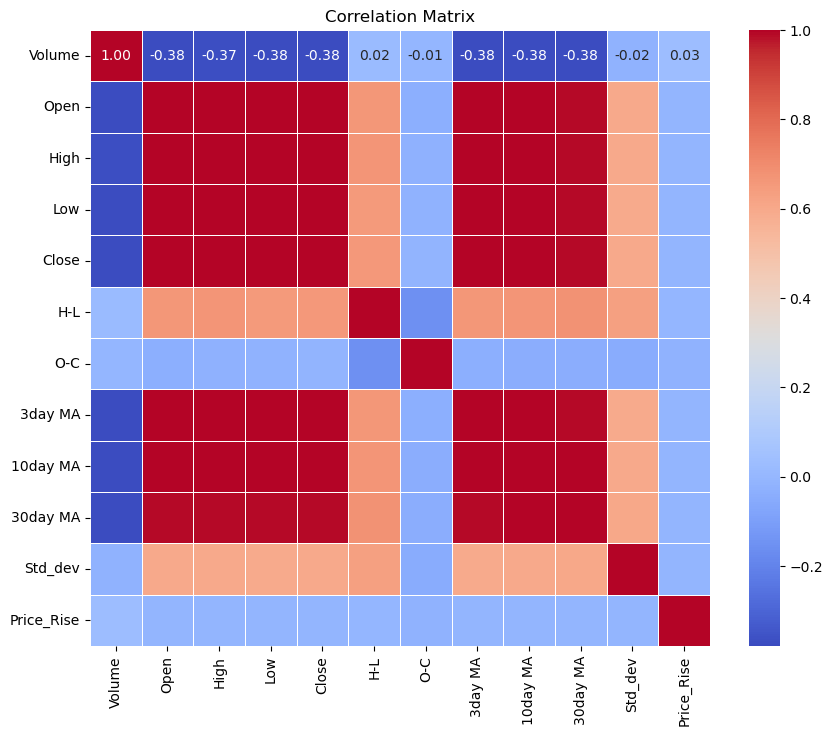

In [40]:
corr_matrix = SONY.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()


In [42]:
# Set target variable y (Price_Rise 0 or 1) and features x (from H-L column to Std_dev column)
X = SONY.iloc[:, 5:-1] 
Y = SONY.iloc[:, -1]

In [43]:
X

,H-L,O-C,3day MA,10day MA,30day MA,Std_dev
Date,,,,,,
2014-02-14,0.339998,0.269999,17.210000,16.465000,16.893000,0.241412
2014-02-18,0.189999,0.040001,17.193333,16.596000,16.889667,0.124016
2014-02-19,0.230000,-0.040001,17.200000,16.805000,16.895000,0.132741
2014-02-20,0.240000,0.070000,17.156666,16.902000,16.887333,0.113886
2014-02-21,0.209999,-0.119999,17.193333,17.029000,16.882333,0.113886
...,...,...,...,...,...,...
2023-12-22,0.790001,0.389999,91.486669,91.259001,88.019667,1.023337
2023-12-26,1.440002,1.239998,91.660001,91.543001,88.366667,1.283347
2023-12-27,0.590004,0.389999,92.790001,91.957001,88.617667,1.522685


In [44]:
# Split the data into training and testing sets

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, 
                                   shuffle=False)
X_test

,H-L,O-C,3day MA,10day MA,30day MA,Std_dev
Date,,,,,,
2022-01-06,3.939995,-2.290001,127.806664,126.407999,123.263000,2.243306
2022-01-07,2.439995,-1.190002,126.753332,126.409000,123.307333,2.469902
2022-01-10,2.529999,-0.330002,125.336665,126.453999,123.377000,2.804338
2022-01-11,2.529999,2.059998,123.529999,126.049999,123.440333,2.344013
2022-01-12,1.389999,0.820000,124.599998,125.933999,123.603000,1.842912
...,...,...,...,...,...,...
2023-12-22,0.790001,0.389999,91.486669,91.259001,88.019667,1.023337
2023-12-26,1.440002,1.239998,91.660001,91.543001,88.366667,1.283347
2023-12-27,0.590004,0.389999,92.790001,91.957001,88.617667,1.522685


In [45]:
# Standardize the features (optional but can be beneficial for 
#logistic regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
# Model
modellr = LogisticRegression(random_state=101)
# Train the model
modellr.fit(X_train, Y_train)
# Predict on the test set
Y_pred = modellr.predict(X_test)

print (classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.48      0.11      0.17       256
           1       0.48      0.88      0.62       242

    accuracy                           0.48       498
   macro avg       0.48      0.49      0.40       498
weighted avg       0.48      0.48      0.39       498



In [47]:
#Model
modelet = ExtraTreesClassifier(random_state=101)
# Train the model
modelet.fit(X_train, Y_train)
# Predict on the test set
Y_pred = modelet.predict(X_test)

print (classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.51      0.42      0.46       256
           1       0.48      0.57      0.52       242

    accuracy                           0.49       498
   macro avg       0.49      0.49      0.49       498
weighted avg       0.49      0.49      0.49       498



In [48]:
accuracy_scores = cross_val_score(modellr, X, Y, cv=5, 
                scoring=make_scorer(accuracy_score))

# Print mean and standard deviation of accuracy
print(f"Mean Accuracy: {accuracy_scores.mean():.2f}")
print(f"Standard Deviation: {accuracy_scores.std():.2f}")

Mean Accuracy: 0.51
Standard Deviation: 0.01


In [49]:
accuracy_scores = cross_val_score(modelet, X, Y, cv=5, 
                scoring=make_scorer(accuracy_score))

# Mean and standard deviation of accuracy
print(f"Mean Accuracy: {accuracy_scores.mean():.2f}")
print(f"Standard Deviation Accuracy: {accuracy_scores.std():.2f}")

Mean Accuracy: 0.48
Standard Deviation Accuracy: 0.03


In [50]:
modelet = ExtraTreesClassifier(random_state=101)
modelet.fit(X_train, Y_train)
Y_pred = modelet.predict(X_test)

classification_rep = classification_report(Y_test, Y_pred)
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.42      0.46       256
           1       0.48      0.57      0.52       242

    accuracy                           0.49       498
   macro avg       0.49      0.49      0.49       498
weighted avg       0.49      0.49      0.49       498



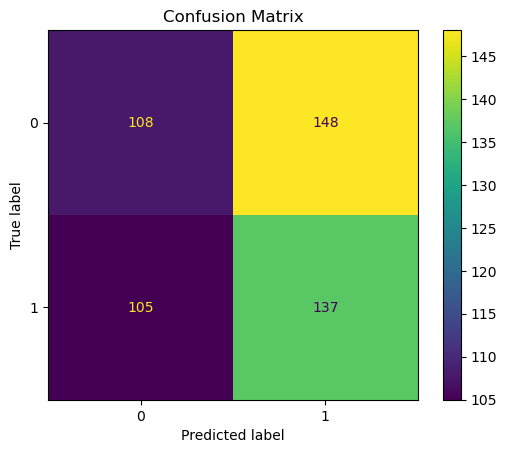

In [51]:
# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Evaluate the modelet by means of a Confusion Matrix
matrix = ConfusionMatrixDisplay.from_estimator(modelet, X_test, Y_test)  
plt.title('Confusion Matrix')
plt.show(matrix)
plt.show()

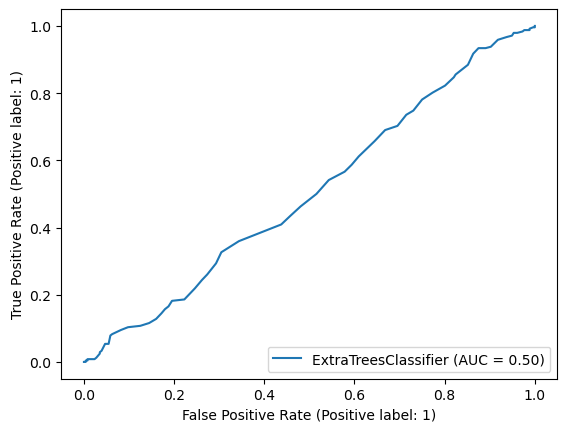

In [52]:
# ROC Curve
log_disp = RocCurveDisplay.from_estimator(modelet, X_test, Y_test)

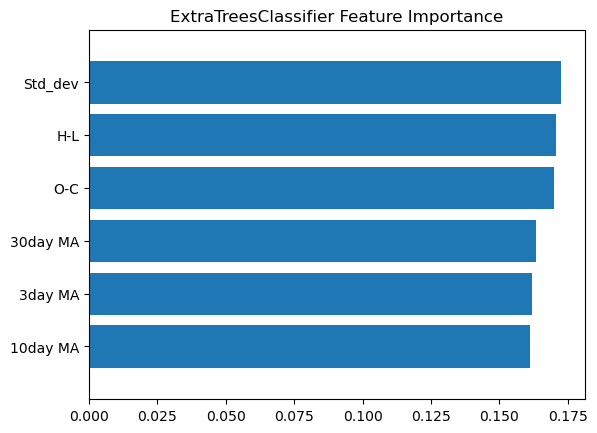

In [53]:
#Importance of classifiers 
feature_names=X.columns
importance = modelet.feature_importances_ 
indices = np.argsort(importance)
range1 = range(len(importance[indices]))
plt.figure()
plt.title("ExtraTreesClassifier Feature Importance")
plt.barh(range1,importance[indices])
plt.yticks(range1, feature_names[indices])
plt.ylim([-1, len(range1)])
plt.show()

In [57]:
#Create new column Y_pred
SONY['Y_pred'] = np.NaN
SONY.iloc[(len(SONY) - len(Y_pred)):,-1] = Y_pred
trade_SONY = SONY.dropna()
trade_SONY

,Volume,Open,High,Low,Close,H-L,O-C,3day MA,10day MA,30day MA,Std_dev,Price_Rise,Y_pred
Date,,,,,,,,,,,,,
2022-01-06,1836500,125.400002,126.309998,122.370003,123.110001,3.939995,-2.290001,127.806664,126.407999,123.263000,2.243306,1,1.0
2022-01-07,574800,125.500000,125.739998,123.300003,124.309998,2.439995,-1.190002,126.753332,126.409000,123.307333,2.469902,0,1.0
2022-01-10,1031200,123.500000,123.699997,121.169998,123.169998,2.529999,-0.330002,125.336665,126.453999,123.377000,2.804338,1,1.0
2022-01-11,799200,124.260002,126.379997,123.849998,126.320000,2.529999,2.059998,123.529999,126.049999,123.440333,2.344013,1,1.0
2022-01-12,345600,126.330002,127.650002,126.260002,127.150002,1.389999,0.820000,124.599998,125.933999,123.603000,1.842912,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,531900,91.750000,92.300003,91.510002,92.139999,0.790001,0.389999,91.486669,91.259001,88.019667,1.023337,1,1.0
2023-12-26,660400,92.230003,93.650002,92.209999,93.470001,1.440002,1.239998,91.660001,91.543001,88.366667,1.283347,1,1.0
2023-12-27,585400,93.620003,94.050003,93.459999,94.010002,0.590004,0.389999,92.790001,91.957001,88.617667,1.522685,1,0.0


In [58]:
trade_SONY['Tomorrows Returns'] = 0.
trade_SONY['Tomorrows Returns'] = np.log(trade_SONY['Close']/trade_SONY['Close'].shift(1))
trade_SONY['Tomorrows Returns'] = trade_SONY['Tomorrows Returns'].shift(-1)
trade_SONY

,Volume,Open,High,Low,Close,H-L,O-C,3day MA,10day MA,30day MA,Std_dev,Price_Rise,Y_pred,Tomorrows Returns
Date,,,,,,,,,,,,,,
2022-01-06,1836500,125.400002,126.309998,122.370003,123.110001,3.939995,-2.290001,127.806664,126.407999,123.263000,2.243306,1,1.0,0.009700
2022-01-07,574800,125.500000,125.739998,123.300003,124.309998,2.439995,-1.190002,126.753332,126.409000,123.307333,2.469902,0,1.0,-0.009213
2022-01-10,1031200,123.500000,123.699997,121.169998,123.169998,2.529999,-0.330002,125.336665,126.453999,123.377000,2.804338,1,1.0,0.025253
2022-01-11,799200,124.260002,126.379997,123.849998,126.320000,2.529999,2.059998,123.529999,126.049999,123.440333,2.344013,1,1.0,0.006549
2022-01-12,345600,126.330002,127.650002,126.260002,127.150002,1.389999,0.820000,124.599998,125.933999,123.603000,1.842912,0,0.0,-0.018655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,531900,91.750000,92.300003,91.510002,92.139999,0.790001,0.389999,91.486669,91.259001,88.019667,1.023337,1,1.0,0.014331
2023-12-26,660400,92.230003,93.650002,92.209999,93.470001,1.440002,1.239998,91.660001,91.543001,88.366667,1.283347,1,1.0,0.005761
2023-12-27,585400,93.620003,94.050003,93.459999,94.010002,0.590004,0.389999,92.790001,91.957001,88.617667,1.522685,1,0.0,0.006785


In [60]:
#Strategy Returns based on Y_Pred
trade_SONY['Strategy Returns'] = 0.
trade_SONY['Strategy Returns'] = np.where(trade_SONY['Y_pred'] == True,
                                 trade_SONY['Tomorrows Returns'], - trade_SONY['Tomorrows Returns'])
trade_SONY

,Volume,Open,High,Low,Close,H-L,O-C,3day MA,10day MA,30day MA,Std_dev,Price_Rise,Y_pred,Tomorrows Returns,Strategy Returns
Date,,,,,,,,,,,,,,,
2022-01-06,1836500,125.400002,126.309998,122.370003,123.110001,3.939995,-2.290001,127.806664,126.407999,123.263000,2.243306,1,1.0,0.009700,0.009700
2022-01-07,574800,125.500000,125.739998,123.300003,124.309998,2.439995,-1.190002,126.753332,126.409000,123.307333,2.469902,0,1.0,-0.009213,-0.009213
2022-01-10,1031200,123.500000,123.699997,121.169998,123.169998,2.529999,-0.330002,125.336665,126.453999,123.377000,2.804338,1,1.0,0.025253,0.025253
2022-01-11,799200,124.260002,126.379997,123.849998,126.320000,2.529999,2.059998,123.529999,126.049999,123.440333,2.344013,1,1.0,0.006549,0.006549
2022-01-12,345600,126.330002,127.650002,126.260002,127.150002,1.389999,0.820000,124.599998,125.933999,123.603000,1.842912,0,0.0,-0.018655,0.018655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,531900,91.750000,92.300003,91.510002,92.139999,0.790001,0.389999,91.486669,91.259001,88.019667,1.023337,1,1.0,0.014331,0.014331
2023-12-26,660400,92.230003,93.650002,92.209999,93.470001,1.440002,1.239998,91.660001,91.543001,88.366667,1.283347,1,1.0,0.005761,0.005761
2023-12-27,585400,93.620003,94.050003,93.459999,94.010002,0.590004,0.389999,92.790001,91.957001,88.617667,1.522685,1,0.0,0.006785,-0.006785


In [62]:
trade_SONY['Cumulative Market Returns'] = np.cumsum(trade_SONY['Tomorrows Returns'])
trade_SONY['Cumulative Strategy Returns'] = np.cumsum(trade_SONY['Strategy Returns'])

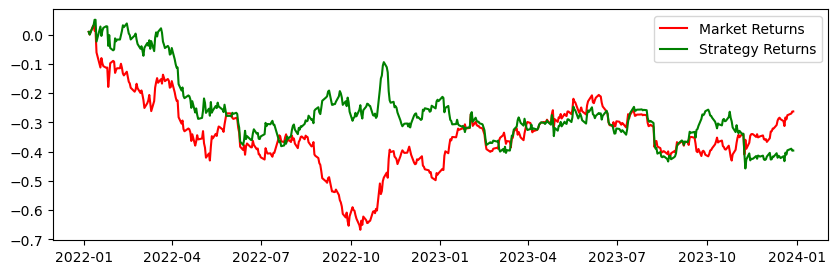

In [63]:
plt.figure(figsize=(10,3))
plt.plot(trade_SONY['Cumulative Market Returns'], color='r', label='Market Returns')
plt.plot(trade_SONY['Cumulative Strategy Returns'], color='g', label='Strategy Returns')
plt.legend()
plt.show()